In [1]:
import numpy as np 
import pandas as pd 
import h5py 
import matplotlib.pyplot as plt

In [2]:
def zero_pad(X,pad):
    """ 
    this function is going to take a batch and will apply zero padding to its all images 

    arguments:
    X -- a batch with shape = (number,heith,widght,depth)
    pad -- number of padding from each side 

    returns:
    padded_X -- a padded batch with the shape of (number,heith+2pad,width+2pad,depth)
    """

    pad_X = np.pad(X,[(0,0),(pad,pad),(pad,pad),(0,0)],mode="constant",constant_values=(0,0))

    return pad_X

In [3]:
arr = np.array(np.random.randn(4,2,2,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


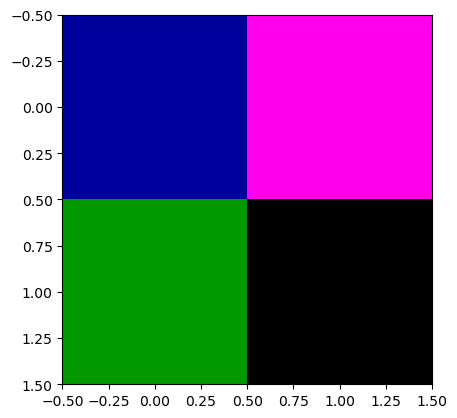

In [4]:
plt.imshow(arr[0])

In [5]:
pad_arr = zero_pad(arr,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


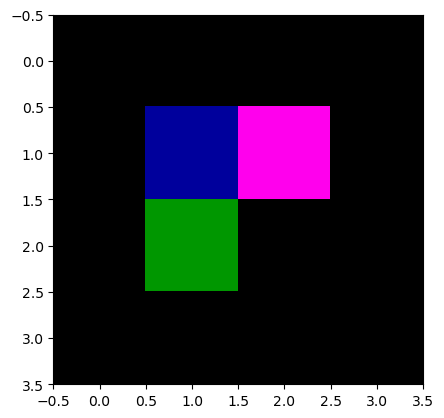

In [6]:
plt.imshow(pad_arr[0])

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


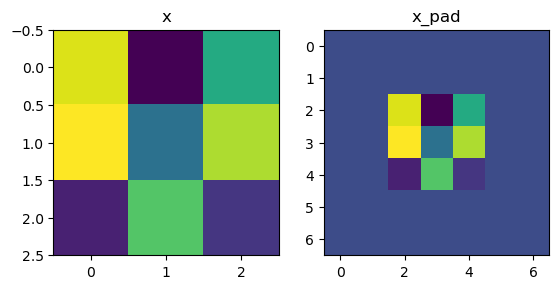

In [7]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [8]:
def conv_single_step(s,k,b):
    """ 
    this will apply convolotion to a one slice of a image 

    arguments:
    s -- slice of a image in shape of k (kernel)
    k -- kernel 
    b -- bias 

    return:
    z -- a scalar or reasult of convolution value 
    """

    temp = np.multiply(s,k)
    z = np.sum(temp)
    z += float(b[0][0][0]) 

    return z


In [9]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


In [10]:
def conv_forward(A_prev,filters,b,hparameters):
    """  
    this will implement convnet forward pass 

    arguments :
    A_prev -- input batch of conv layer with shape of (m,h_prev,w_prev,n_c_prev)
    filters -- the stacked filters as cube with shape of (f,f,n_c_prev,n_c)
    b -- bias term with the shape of (1,1,n_c)
    hparameters -- a dictionary cocluding stride and pad 

    returns :
    A -- the result of convolotion layer 
    chache -- detail for backpropagation part 
    """

    pad = hparameters["pad"]
    stride = hparameters["stride"]

    (m_batch,h_prev,w_prev,n_c_prev) = A_prev.shape
    (f,_,_,n_c_new) = filters.shape

    assert(filters.shape[2] == A_prev.shape[3])

    h_new = int(np.floor((h_prev+2*pad-f)/stride)+1)
    w_new = int(np.floor((w_prev+2*pad-f)/stride)+1)
    #print(h_new , w_new)
    A_prev_pad = zero_pad(A_prev,pad)

    A = np.zeros((m_batch,h_new,w_new,n_c_new))

    for m in range(m_batch) :

        for h in range(h_new):

            h_start = h*stride   
            h_end = h_start + f 

            for w in range(w_new):

                w_start = w*stride
                w_end = w_start + f 

                for c in range(n_c_new):

                    slice_ = A_prev_pad[m,h_start:h_end , w_start:w_end , :]
                    filter_ = filters[:,:,:,c]
                    bias = b[:,:,:,c]
                    #print(slice_.shape , filter_.shape , bias.shape,m,h,w,c)
                    z = conv_single_step(slice_,filter_,bias)
                    A[m,h,w,c] = z 


    assert(A.shape == (m_batch,h_new,w_new,n_c_new))

    cache = (A_prev , filters,b,hparameters)

    return A , cache 


In [11]:

np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


**Expected Output**:
```
Z's mean =
 0.692360880758
Z[3,2,1] =
 [ -1.28912231   2.27650251   6.61941931   0.95527176   8.25132576
   2.31329639  13.00689405   2.34576051]
cache_conv[0][1][2][3] = [-1.1191154   1.9560789  -0.3264995  -1.34267579]
```

In [12]:
def pool_forward(A_prev,hparameters,mode="max"):
    """  
    this will implement convnet polling layer forward pass 

    arguments :
    A_prev -- input batch of conv layer with shape of (m,h_prev,w_prev,n_c_prev)
    hparameters -- a dictionary cocluding stride and f as size of pooling kernel 
    mode -- show mode of poolling this take "max" or "avrage"

    returns :
    A -- the result of convolotion layer 
    chache -- detail for backpropagation part 
    """

    f = hparameters["f"]
    stride = hparameters["stride"]

    (m_batch,h_prev,w_prev,n_c_prev) = A_prev.shape

    h_new = int(np.floor((h_prev-f)/stride)+1)
    w_new = int(np.floor((w_prev-f)/stride)+1)

    A = np.zeros((m_batch,h_new,w_new,n_c_prev))

    for m in range(m_batch) :

        for h in range(h_new):

            h_start = h*stride   
            h_end = h_start + f 

            for w in range(w_new):

                w_start = w*stride
                w_end = w_start + f 

                for c in range(n_c_prev):

                    slice_ = A_prev[m,h_start:h_end , w_start:w_end , c]
                    if mode == "max":
                        z = np.max(slice_)
                    elif mode == "average":
                        z = np.average(slice_) 
                    else:
                        print("invalid mode")   

                    A[m,h,w,c] = z

    assert(A.shape == (m_batch,h_new,w_new,n_c_prev))

    cache = (A_prev,hparameters)

    return A , cache 


In [13]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [

** Expected Output**
```
mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.46210794  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.14472371  0.90159072  2.10025514]
   [ 1.14472371  0.90159072  1.65980218]
   [ 1.14472371  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  0.84616065  1.2245077 ]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.84616065  1.27375593]
   [ 1.96710175  0.84616065  1.23616403]
   [ 1.62765075  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.96710175  0.86888616  1.23616403]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[ -3.01046719e-02  -3.24021315e-03  -3.36298859e-01]
   [  1.43310483e-01   1.93146751e-01  -4.44905196e-01]
   [  1.28934436e-01   2.22428468e-01   1.25067597e-01]]

  [[ -3.81801899e-01   1.59993515e-02   1.70562706e-01]
   [  4.73707165e-02   2.59244658e-02   9.20338402e-02]
   [  3.97048605e-02   1.57189094e-01   3.45302489e-01]]

  [[ -3.82680519e-01   2.32579951e-01   6.25997903e-01]
   [ -2.47157416e-01  -3.48524998e-04   3.50539717e-01]
   [ -9.52551510e-02   2.68511000e-01   4.66056368e-01]]]


 [[[ -1.73134159e-01   3.23771981e-01  -3.43175716e-01]
   [  3.80634669e-02   7.26706274e-02  -2.30268958e-01]
   [  2.03009393e-02   1.41414785e-01  -1.23158476e-02]]

  [[  4.44976963e-01  -2.61694592e-03  -3.10403073e-01]
   [  5.08114737e-01  -2.34937338e-01  -2.39611830e-01]
   [  1.18726772e-01   1.72552294e-01  -2.21121966e-01]]

  [[  4.29449255e-01   8.44699612e-02  -2.72909051e-01]
   [  6.76351685e-01  -1.20138225e-01  -2.44076712e-01]
   [  1.50774518e-01   2.89111751e-01   1.23238536e-03]]]]
```

In [14]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]


**Expected Output:**
    
```
mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]
```

In [38]:
def conv_backward(dz,cache):
    """
    this implement back propagation of convolotion layer in conv net 

    arguments:
    dz -- derivation of layer output Z in shape of (m,n_h,n_w,n_c)
    cache -- tuple including (A_prev , hparameters) . this is result of forward pass

    returns:
    dA_prev -- derivation of input of the layer in shape of (m,h_prev,w_prev,n_c_prev)   
    dw -- derivation of filter in shape of (f,f,n_c_prev,n_c)
    db -- derivation of bias in shape of (1,1,1,n_c)


    """

    (m,n_h , n_w , n_c) = dz.shape 
    #A_prev , hparam = cache[0] , cache[1]
    (A_prev, W, b, hparam) = cache
    f = W.shape[1]
    pad = hparam["pad"]
    stride = hparam["stride"]

    (_,n_h_prev, n_w_prev,n_c_prev) = A_prev.shape 

    dA_prev = np.zeros(A_prev.shape)
    dw = np.zeros(W.shape)
    db = np.zeros(b.shape)

    dA_prev_pad = zero_pad(dA_prev , pad)
    A_prev_pad = zero_pad(A_prev , pad)

    for i in range(m):
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):

                    h_start = h*stride
                    h_end = h_start + f
                    w_start = w*stride 
                    w_end = w_start + f 

                    dA_prev_pad[i,h_start:h_end,w_start:w_end,:] += W[:,:,:,c] * dz[i,h,w,c]

                    dw[:,:,:,c] += A_prev_pad[i,h_start:h_end,w_start:w_end,:] * dz[i,h,w,c]

                    db[:,:,:,c] += dz[i,h,w,c] 

    # for i in range(c):
    #     db[:,:,:,i] /= m 
    #     dw[:,:,:,i] /= m 

    dA_prev_unpad = dA_prev_pad[:,pad:-pad,pad:-pad,:]
    assert(dA_prev_unpad.shape == (m,n_h_prev,n_w_prev,n_c_prev))

    return dA_prev_unpad , dw , db 

In [39]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


** Expected Output: **
<table>
    <tr>
        <td>
            **dA_mean**
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            **dW_mean**
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            **db_mean**
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>


In [40]:
def create_mask_from_window(x):
    """ 
    this create a mask from input window 

    arguments:
    x -- input windows 

    returns :
    mask -- a map of same shape of x and including 1 in place of max and 0 in other place 

    """

    mask = (x == np.max(x)) * 1 

    return mask 



In [42]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask , sep ="\n")

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask = 
[[1 0 0]
 [0 0 0]]


In [43]:
def distribute_value(dz,shape):
    """ 
    we use this for distribute dz in array with form of shape 

    arguments:
    dz -- a scalar gradient 
    shape -- shape for distribution map 

    returns:
    a -- distributed array 
    """ 

    a = np.full(shape=shape,fill_value=dz/(shape[0]*shape[1]))

    return a 

In [46]:
a = distribute_value(2, (2,2))
print('distributed value =',  a, sep="\n")

distributed value =
[[0.5 0.5]
 [0.5 0.5]]


**Expected Output**: 

<table> 
<tr> 
<td>
distributed_value =
</td>
<td>
[[ 0.5  0.5]
<br\> 
[ 0.5  0.5]]
</td>
</tr>
</table>

In [52]:
def pool_backward(dA,cache,mode="max"):
    """ 
    thsi implement back prop of polling layer 

    arguments:
    dA -- gradient of output of layer . shape = (m , n_h,n_w, c_prev)
    cahce -- (A_prev, hparameters)
    mode -- how to pool 

    returns:
    dA_prev -- gradient of previous input with shape of A_prev 

    """

    (m , n_h,n_w, c_prev) = dA.shape 
    (A_prev , hparam) = cache 

    f = hparam["f"]
    stride = hparam["stride"]

    # w_prev = int(((n_w-1)*stride)+f) 
    # h_prev = int(((n_h-1)*stride)+f)

    (_,h_prev,w_prev,_) = A_prev.shape 

    dA_prev = np.zeros((m,h_prev,w_prev,c_prev))


    for i in range(m):
        for h in range(n_h):
            for w in range(n_w):
                for c in range(c_prev):

                    h_start = h*stride
                    h_end = h_start+f
                    w_start = w * stride 
                    w_end = w_start + f 
                    
                    if mode == "max":
                        dA_prev[i,h_start:h_end,w_start:w_end,c] += create_mask_from_window(A_prev[i,h_start:h_end,w_start:w_end,c]) * dA[i,h,w,c]
                    elif mode == "average":
                        dA_prev[i,h_start:h_end,w_start:w_end,c] += distribute_value(dA[i,h,w,c],A_prev[i,h_start:h_end,w_start:w_end,c].shape)

    assert(dA_prev.shape == A_prev.shape)

    return dA_prev


In [53]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


**Expected Output**: 

mode = max:
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.          0.        ] <br>
 [ 5.05844394 -1.68282702] <br>
 [ 0.          0.        ]]
</td>
</tr>
</table>

mode = average
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.08485462  0.2787552 ] <br>
 [ 1.26461098 -0.25749373] <br>
 [ 1.17975636 -0.53624893]]
</td>
</tr>
</table>